<a href="https://colab.research.google.com/github/ryghrmni/DeepLifeProject/blob/robin/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project : Cell image segmentation projects**


---



**Team** (Alphabetical order)**:** Arvin Jafari, Delnavaz Fotouhi, Reza Ghahremani

**University:** Università degli Studi di Milano

** This course is provided by 4EU+ alliance of European universities, Heidelberg University will coordinate a joint course on Applications of Deep Learning in Life Sciences (DeepLife) involving the universities of Paris-Sorbonne, Warsaw, Prague, Milano and Heidelberg.

**Reference:** https://deeplife4eu.github.io/


---



Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide contains both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)

### Project aim

The aim of the project is to download the cell images (preferably from the “2018 Data Science Bowl” competition) and assess the performance of an UNet or any other Deep model for cell segmentation.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


## **Step 1: Data Preparation**

**1.1. Install and Upgrade Kaggle Package**

The Kaggle Python package was installed and upgraded to ensure we have the latest version with all necessary functionalities.

In [1]:
!pip install --upgrade kaggle

**1.2. Verify and Create Kaggle Directory**

We verified if the ~/.kaggle directory exists. If not, the directory was created to store the Kaggle API credentials.

In [3]:
import os

# Verify ~/.kaggle directory exists
kaggle_dir = os.path.expanduser('~/.kaggle')
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
    print("Directory created: ~/.kaggle")
else:
    print("Directory already exists: ~/.kaggle")

Directory created: ~/.kaggle


**1.3. Copy Kaggle JSON to Kaggle Directory**

The kaggle.json file, which contains the API credentials, was copied to the ~/.kaggle directory. Permissions were set to ensure the file is secure.

In [4]:
import shutil

kaggle_json_path = 'kaggle.json'
target_path = os.path.join(kaggle_dir, 'kaggle.json')

if os.path.exists(kaggle_json_path):
    shutil.copy(kaggle_json_path, target_path)
    os.chmod(target_path, 0o600)
    print("kaggle.json has been copied to ~/.kaggle and permissions set.")
else:
    print("kaggle.json not found in the current directory.")

kaggle.json not found in the current directory.


**1.4. Set Environment Variables for Kaggle API**

Environment variables for the Kaggle username and key were set to enable authentication for API requests.

**reference:** https://www.kaggle.com/docs/api

In [6]:
import os
os.environ['KAGGLE_USERNAME'] = input()
os.environ['KAGGLE_KEY'] = input()

arvinjmf
08908e6b7e12d90cd270e1aa2bfc58c9


**1.5. Download Dataset from Kaggle and Extract Dataset**

The dataset for the Data Science Bowl 2018 competition was downloaded using the Kaggle API. The downloaded zip file was extracted into a directory named data.

In [7]:
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:06<00:00, 17.5MB/s]
100% 358M/358M [00:06<00:00, 62.0MB/s]


In [8]:
!unzip data-science-bowl-2018.zip -d data

Archive:  data-science-bowl-2018.zip
  inflating: data/stage1_sample_submission.csv.zip  
  inflating: data/stage1_solution.csv.zip  
  inflating: data/stage1_test.zip    
  inflating: data/stage1_train.zip   
  inflating: data/stage1_train_labels.csv.zip  
  inflating: data/stage2_sample_submission_final.csv.zip  
  inflating: data/stage2_test_final.zip  


**1.6. Navigate to Data Directory and Extract All Files and List Directory Contents**

Changed the current working directory to data and extracted all zip files within it. The original zip files were then deleted. Finally, we listed the contents of the data directory to confirm the successful extraction of the dataset files.

In [9]:
cd data

/content/data


In [10]:
!for file in *.zip; do unzip -q "$file" -d "${file%%.*}" && rm "$file"; done

In [11]:
ls

stage1_sample_submission/  stage1_test/   stage1_train_labels/             stage2_test_final/
stage1_solution/           stage1_train/  stage2_sample_submission_final/


## **Step 2: Data Preprocessing and Augmenation**

**2.1. Stretch Contrast Function**

This function stretches the contrast of an image to utilize the full range of pixel values (0 to 255).

In [12]:
def stretch_contrast(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255.0 / (max_val - min_val))
    return stretched_image.astype(np.uint8)

**2.2. Load Data Function**

The load_data function is designed to load images and their corresponding masks from a given base directory, apply contrast stretching to the images, and organize the data into lists.

In [13]:
# def load_data(base_path):
#     images = []
#     masks = []
#     sample_names = []

#     sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

#     for sample_folder in sample_folders:
#         sample_name = os.path.basename(sample_folder)
#         image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
#         masks_path = os.path.join(sample_folder, 'masks')

#         image = Image.open(image_path)
#         image = np.array(image)
#         stretched_image = stretch_contrast(image)
#         images.append(stretched_image)
#         sample_names.append(sample_name)

#         mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
#         sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
#         masks.append(sample_masks)

#     return images, masks, sample_names

In [14]:
import os
import shutil
import random

# Define the source directory
source_dir = "/content/data/stage1_train"

# Define the destination directory
dest_dir = "/content/data/toy_data"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Get a list of all folders in the source directory
folders = os.listdir(source_dir)

# Randomly select 50 folders
selected_folders = random.sample(folders, 50)

# Copy selected folders to the destination directory
for folder in selected_folders:
    src = os.path.join(source_dir, folder)
    dst = os.path.join(dest_dir, folder)
    shutil.copytree(src, dst)

print("Selected folders have been copied to the 'toy_data' folder.")

Selected folders have been copied to the 'toy_data' folder.


In [15]:
def load_data(base_path):
    images = []
    masks = []
    sample_names = []
    sample_folders = []

    # Get all sample folders
    sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_folder in sample_folders:
        sample_name = os.path.basename(sample_folder)
        image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
        masks_path = os.path.join(sample_folder, 'masks')

        # Load the image and stretch contrast
        image = Image.open(image_path)
        image = np.array(image)
        stretched_image = stretch_contrast(image)
        images.append(stretched_image)
        sample_names.append(sample_name)

        # Load all masks for this sample
        mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
        sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
        masks.append(sample_masks)

    return images, masks, sample_names, sample_folders

In [16]:
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# # Example usage:
# base_path = '/content/data/toy_data'
# images, masks, sample_names = load_data(base_path)

# # Access the first sample
# first_sample_index = 0
# first_sample_name = sample_names[first_sample_index]
# first_sample_image = images[first_sample_index]
# first_sample_masks = masks[first_sample_index]

# # Print the sample name and display the image
# print(f'First sample name: {first_sample_name}')
# plt.figure()
# plt.imshow(first_sample_image)
# plt.title(f'Image: {first_sample_name}')
# plt.axis('off')
# plt.show()

# # Display the masks
# for i, mask in enumerate(first_sample_masks):
#     plt.figure()
#     plt.imshow(mask, cmap='gray')
#     plt.title(f'Mask {i + 1} for sample {first_sample_name}')
#     plt.axis('off')
#     plt.show()

# # Merge and display the masks
# merged_mask = merge_masks(first_sample_masks)

# plt.figure()
# plt.imshow(merged_mask, cmap='gray')
# plt.title(f'Merged Mask for sample {first_sample_name}')
# plt.axis('off')
# plt.show()

**2.3. Merge Masks Function**

This function merges multiple masks by adding the values of corresponding pixels.

In [17]:
def merge_masks(masks):
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        mask_uint8 = mask.astype(np.uint8)
        merged_mask += mask_uint8
    return merged_mask

**2.4. Mask Merging**

The masks are merged to create a single composite mask for each sample, which is then saved for further analysis.

In [18]:
import numpy as np
from PIL import Image

In [19]:
# This function saves the merged mask as an image file in the 'merged_masks' folder within the sample folder.
def save_merged_mask(merged_mask, sample_folder):
    merged_masks_dir = os.path.join(sample_folder, 'merged_masks')
    os.makedirs(merged_masks_dir, exist_ok=True)
    sample_name = os.path.basename(sample_folder)
    output_path = os.path.join(merged_masks_dir, f"{sample_name}_merged_mask.png")
    merged_mask_image = Image.fromarray(merged_mask)
    merged_mask_image.save(output_path)
    print(f"Merged mask saved at: {output_path}")

In [20]:
# This function loads the data, merges the masks for each sample, and saves the merged masks in the corresponding folders.
def process_and_save_merged_masks(base_path):
    images, masks, sample_names, sample_folders = load_data(base_path)
    for sample_name, sample_masks, sample_folder in zip(sample_names, masks, sample_folders):
        merged_mask = merge_masks(sample_masks)
        save_merged_mask(merged_mask, sample_folder)

In [21]:
base_path = '/content/data/toy_data'
process_and_save_merged_masks(base_path)

Merged mask saved at: /content/data/toy_data/2dec81a678ddcac2b110acffe82427d857695180bd841e3f9736a554acf832af/merged_masks/2dec81a678ddcac2b110acffe82427d857695180bd841e3f9736a554acf832af_merged_mask.png
Merged mask saved at: /content/data/toy_data/e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367/merged_masks/e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367_merged_mask.png
Merged mask saved at: /content/data/toy_data/61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e/merged_masks/61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e_merged_mask.png
Merged mask saved at: /content/data/toy_data/1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180/merged_masks/1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180_merged_mask.png
Merged mask saved at: /content/data/toy_data/942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0/merged_masks/942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850

In [22]:
base_path = '/content/data/stage1_train'
process_and_save_merged_masks(base_path)

Merged mask saved at: /content/data/stage1_train/74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94/merged_masks/74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94_merged_mask.png
Merged mask saved at: /content/data/stage1_train/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf/merged_masks/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf_merged_mask.png
Merged mask saved at: /content/data/stage1_train/56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c875b0acb207d1c5/merged_masks/56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c875b0acb207d1c5_merged_mask.png
Merged mask saved at: /content/data/stage1_train/2dec81a678ddcac2b110acffe82427d857695180bd841e3f9736a554acf832af/merged_masks/2dec81a678ddcac2b110acffe82427d857695180bd841e3f9736a554acf832af_merged_mask.png
Merged mask saved at: /content/data/stage1_train/e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367/merged_masks/e5a7b8a9924b26b3abf039255a8a3bb00258f4966

**2.4. Data organization**

In [23]:
import os
import shutil
from PIL import Image

def extract_images(stage1_path, destination_path, content_type='images'):
    """
    Extract all images or merged masks from the stage1_train or stage1_test folder and save them into the specified destination folder.

    Args:
    - stage1_path (str): Path to the stage1_train or stage1_test folder containing sample folders.
    - destination_path (str): Path to the destination folder where images or masks will be saved.
    - content_type (str): Type of content to extract ('images' or 'merged_masks').
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Determine the subfolder to look for based on content type
    subfolder_name = 'images' if content_type == 'images' else 'merged_masks'

    # Iterate over all sample folders in the stage1 directory
    for sample_folder in os.listdir(stage1_path):
        sample_folder_path = os.path.join(stage1_path, sample_folder, subfolder_name)

        # Check if the sample folder contains the specified subfolder
        if os.path.isdir(sample_folder_path):
            for file in os.listdir(sample_folder_path):
                if file.endswith('.png'):
                    # Construct the full path to the file
                    file_path = os.path.join(sample_folder_path, file)

                    # Save the file to the destination directory
                    destination_file_path = os.path.join(destination_path, f"{sample_folder}_{file}")
                    shutil.copy(file_path, destination_file_path)
                    print(f"Copied: {file_path} to {destination_file_path}")

In [24]:
def main(destination_path):
    if 'train/images' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'images'
    elif 'train/masks' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'masks'
    elif 'test/images' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'images'
    else:
        print("Invalid destination path")
        return

    extract_images(stage1_path, destination_path, content_type)

In [25]:
destination_path = '/content/data/train/images'
main(destination_path)

destination_path = '/content/data/train/masks'
main(destination_path)

destination_path = '/content/data/test/images'
main(destination_path)

Copied: /content/data/stage1_train/74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94/images/74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94.png to /content/data/train/images/74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94_74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94.png
Copied: /content/data/stage1_train/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf/images/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf.png to /content/data/train/images/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf_01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf.png
Copied: /content/data/stage1_train/56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c875b0acb207d1c5/images/56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c875b0acb207d1c5.png to /content/data/train/images/56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c875b0acb207d1c5_56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c

In [26]:
!pip install opencv-python-headless matplotlib scikit-image tqdm tensorflow tensorflow-datasets


In [27]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [28]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [29]:
images_path = "/content/data/train/images"
masks_path = "/content/data/train/masks"

In [30]:
OUTPUT_CHANNELS = 2
classes = {'nothing':0, 'nucleon':1}

In [31]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image

In [32]:
#Capture training image info as a list
images_paths = []
masks_paths = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

In [33]:
images_paths.sort()
masks_paths.sort()

In [38]:
# should be implemented with datagenerator that is been defined in the below cells
# Resize images
SIZE_X = 256
SIZE_Y = 256

# Capture training image info as a list
train_images = []
train_masks = []

for imgpath in tqdm.tqdm(images_paths):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = preprocessing(img)
    train_images.append(img)

for maskpath in tqdm.tqdm(masks_paths):
    mask0 = cv2.imread(maskpath, 0)
    mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
    # Assuming that 'class1' is the class you want to keep and 'bg' is the background class
    mask1[mask1 != classes['nothing']] = classes['nucleon']  # Set all classes except 'class1' to background
    train_masks.append(mask1)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.10, shuffle=True, random_state=1)
print("Class values: ", np.unique(y_train))

100%|██████████| 670/670 [00:00<00:00, 728.32it/s]


Class values:  [0 1]


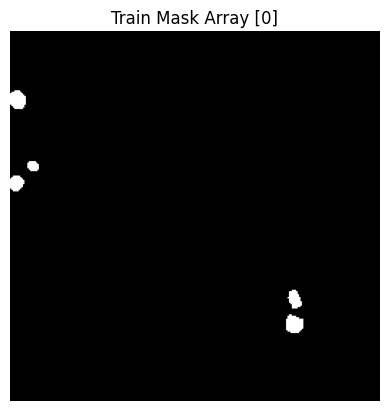

In [39]:
# Plot the mask
plt.imshow(train_masks[19], cmap='gray')  # Use 'gray' colormap for a binary mask
plt.title('Train Mask Array [0]')
plt.axis('off')  # Turn off axis labels
plt.show()

In [40]:
train_masks.shape

(670, 256, 256)

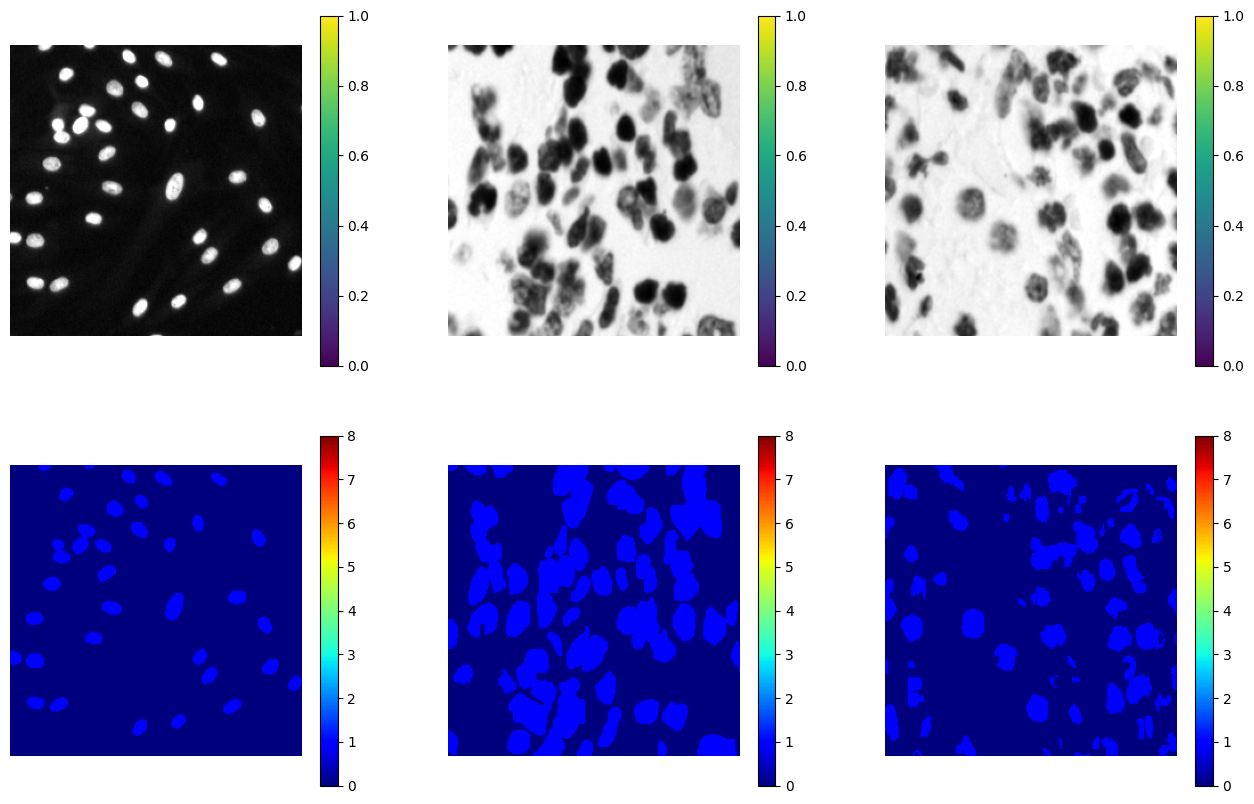

In [41]:
NORM = mpl.colors.Normalize(vmin=0, vmax=8)

plt.figure(figsize=(16,10))
for i in range(1,4):
    plt.subplot(2,3,i)
    img = train_images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

for i in range(4,7):
    plt.subplot(2,3,i)
    img = np.squeeze(train_masks[i-3])
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [42]:
def unet_model(output_channels):
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    base_model = MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(OUTPUT_CHANNELS, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [43]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(epoch, dataset=None, num=5):
  if dataset:

    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        plt.figure(figsize=(15, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(image[0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(mask[0], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(create_mask(pred_mask), cmap='jet')

        plt.savefig(f"results/mask_{str(ii)}.png")

        plt.show()
  else:
      fig = plt.figure(figsize=(12, 12))
      fig.suptitle(f"\n Epoch: {str(epoch)}\n", fontsize=16)

      plt.subplot(331)
      plt.title('Testing Image')
      plt.imshow(train_images[num], cmap='gray')
      plt.subplot(332)
      plt.title('Ground Truth')
      plt.imshow(train_masks[num], cmap='jet')
      plt.subplot(333)
      plt.title('Prediction on test image')
      plt.imshow(create_mask(model.predict(train_images[num][tf.newaxis, ...]))[:,:,0], cmap='jet')

      plt.subplot(334)
      plt.imshow(train_images[num+16], cmap='gray')
      plt.subplot(335)
      plt.imshow(train_masks[num+16], cmap='jet')
      plt.subplot(336)
      plt.imshow(create_mask(model.predict(train_images[num+16][tf.newaxis, ...]))[:,:,0], cmap='jet')
      plt.subplot(337)
      plt.imshow(train_images[num+14], cmap='gray')
      plt.subplot(338)
      plt.imshow(train_masks[num+14], cmap='jet')
      plt.subplot(339)
      plt.imshow(create_mask(model.predict(train_images[num+14][tf.newaxis, ...]))[:,:,0], cmap='jet')

      #plt.savefig(f"results/mask_{str(num+100)}_{str(epoch)}.png")

      plt.show()

In [44]:
import tensorflow as tf

# Define the Dice loss function
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    # Ensure that the channel dimension matches for y_pred
    y_pred = y_pred[:, :, :, 1]  # Assuming the second channel represents the positive class
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)  # Add smoothing to avoid division by zero


In [45]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])   #metrics=[tf.keras.metrics.MeanIoU(num_classes=9)])

9406464/9406464 [==============================] - 0s 0us/step


In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 128, 128, 96),       1841984   ['input_2[0][0]']             
                              (None, 64, 64, 144),                                                
                              (None, 32, 32, 192),                                                
                              (None, 16, 16, 576),                                                
                              (None, 8, 8, 320)]                                                  
                                                                                            

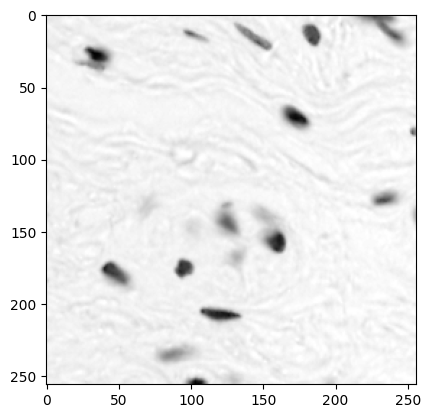

In [47]:
plt.imshow(X_train[89])

1/1 [==============================] - 0s 142ms/step


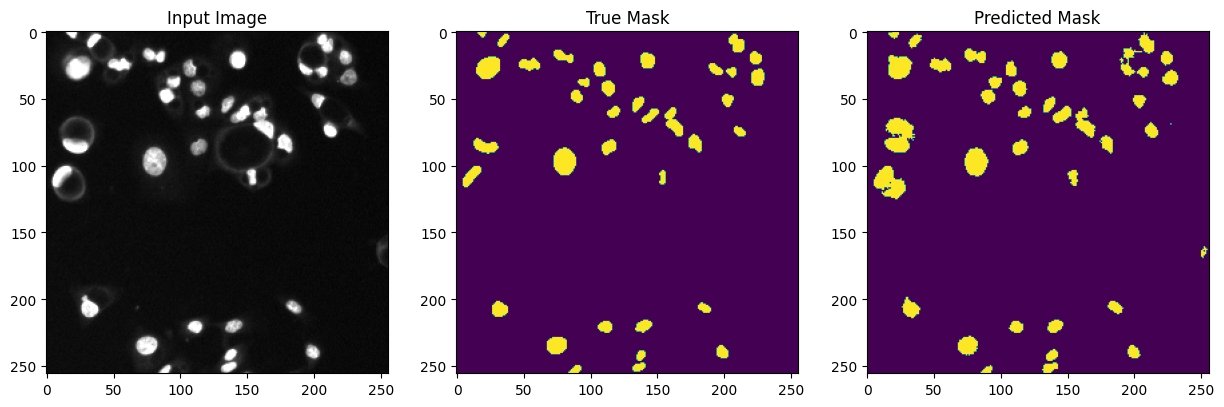


Sample Prediction after epoch 1

42/42 [==============================] - 319s 8s/step - loss: 0.0769 - accuracy: 0.9684 - val_loss: 0.0727 - val_accuracy: 0.9698


StopIteration: 

In [69]:
import tensorflow as tf
import cv2
import numpy as np
import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# Parameters
EPOCHS = 1
BATCH_SIZE = 16
SIZE_X = 256
SIZE_Y = 256
VAL_SUBSPLITS = 5

# Preprocessing function for images
def preprocess_image(img):
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = preprocessing(img)  # Assuming preprocessing is a predefined function
    return img

# Preprocessing function for masks
def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
    mask[mask != classes['nothing']] = classes['nucleon']  # Set all classes except 'class1' to background
    return mask


def post_process_mask(mask, kernel_size=7, min_area=35, blur_kernel_size=3, debug=False):
    """
    Post-process the predicted mask to remove noise and smooth edges with minimal effect.

    Parameters:
    mask (np.array): Predicted mask.
    kernel_size (int): Size of the kernel for morphological operations.
    min_area (int): Minimum area for connected components to keep.
    blur_kernel_size (int): Kernel size for Gaussian blur to smooth edges.
    debug (bool): If True, plot intermediate steps for debugging.

    Returns:
    np.array: Post-processed mask.
    """
    if mask.ndim > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    if debug:
        plt.figure(figsize=(15, 15))
        plt.subplot(1, 4, 1)
        plt.title("Binary Mask")
        plt.imshow(mask, cmap='gray')

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    if debug:
        plt.subplot(1, 4, 2)
        plt.title("Opened Mask")
        plt.imshow(opened_mask, cmap='gray')

    closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel)

    if debug:
        plt.subplot(1, 4, 3)
        plt.title("Closed Mask")
        plt.imshow(closed_mask, cmap='gray')

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed_mask, connectivity=8)
    output_mask = np.zeros_like(closed_mask)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            output_mask[labels == i] = 255

    if debug:
        plt.subplot(1, 4, 4)
        plt.title("Filtered Mask")
        plt.imshow(output_mask, cmap='gray')
        plt.show()


    return output_mask




# Function to read and preprocess images for the generator
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = preprocess_image(img)
    return img

# Function to read and preprocess masks for the generator
def load_and_preprocess_mask(mask_path):
    mask = preprocess_mask(mask_path)
    return mask

# Create a custom data generator for test images
def train_image_generator(image_paths):
    while True:
        for i in range(0, len(image_paths), BATCH_SIZE):
            batch_image_paths = image_paths[i:i+BATCH_SIZE]
            batch_images = [load_and_preprocess_image(img_path) for img_path in batch_image_paths]
            batch_images = np.array(batch_images)
            yield batch_images

        # Add termination condition
        break  # Exit the generator loop once all batches are yielded

# Create a custom data generator for test masks
def train_mask_generator(mask_paths):
    while True:
        for i in range(0, len(mask_paths), BATCH_SIZE):
            batch_mask_paths = mask_paths[i:i+BATCH_SIZE]
            batch_masks = [load_and_preprocess_mask(mask_path) for mask_path in batch_mask_paths]
            batch_masks = np.array(batch_masks)
            yield batch_masks

        # Add termination condition
        break  # Exit the generator loop once all batches are yielded

# Function to show predictions SHOULD ADD THE POST PROCESED MASKED
def show_predictions(epoch):
    test_img = X_val[0]
    true_mask = y_val[0]

    pred_mask = create_mask(model.predict(test_img[tf.newaxis, ...]))

    plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(test_img)

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(np.squeeze(true_mask))

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.squeeze(pred_mask))

    plt.show()

# Display callback for showing predictions
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(epoch)
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))


# Create generator for the test data
train_img_generator = train_image_generator(images_paths)
train_msk_generator = train_mask_generator(masks_paths)

# in the future the dataloader should separately produce img and mask folders for validation
val_img_generator = train_image_generator(images_paths)
val_msk_generator = train_mask_generator(masks_paths)

# Zip the generators
train_generator = zip(train_img_generator, train_msk_generator)
val_generator = zip(val_img_generator, val_msk_generator)

# Training the model with generators
STEPS_PER_EPOCH = len(images_paths) // BATCH_SIZE
VALIDATION_STEPS = len(images_paths) // BATCH_SIZE

model_history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    # steps_per_epoch=STEPS_PER_EPOCH,
    # validation_steps=VALIDATION_STEPS,
    callbacks=[DisplayCallback()]
)

# Evaluate the model performance on the validation set
val_loss, val_mean_iou = model.evaluate(val_generator, steps=VALIDATION_STEPS)
print(f"Validation Loss: {val_loss}")
print(f"Validation Mean IoU: {val_mean_iou}")


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# # Parameters
# EPOCHS = 1
# BATCH_SIZE = 16
# SIZE_X = 256
# SIZE_Y = 256
# VAL_SUBSPLITS = 5


# # Function to show predictions
# def show_predictions(epoch):
#     test_img = X_val[0]
#     true_mask = y_val[0]

#     pred_mask = create_mask(model.predict(test_img[tf.newaxis, ...]))

#     plt.figure(figsize=(15, 15))

#     plt.subplot(1, 3, 1)
#     plt.title("Input Image")
#     plt.imshow(test_img)

#     plt.subplot(1, 3, 2)
#     plt.title("True Mask")
#     plt.imshow(np.squeeze(true_mask))

#     plt.subplot(1, 3, 3)
#     plt.title("Predicted Mask")
#     plt.imshow(np.squeeze(pred_mask))

#     plt.show()

# # Display callback for showing predictions
# class DisplayCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         show_predictions(epoch)
#         print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

# # Create data generators
# datagen = ImageDataGenerator()

# # Create generators for training and validation data
# train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
# val_generator = datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# # Training the model with generators
# STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
# VALIDATION_STEPS = len(X_val) // BATCH_SIZE

# model_history = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     # steps_per_epoch=STEPS_PER_EPOCH,
#     # validation_steps=VALIDATION_STEPS,
#     callbacks=[DisplayCallback()]
# )

# # Evaluate the model performance on the validation set
# val_loss, val_mean_iou = model.evaluate(val_generator, steps=VALIDATION_STEPS)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Mean IoU: {val_mean_iou}")


In [50]:
# to re run the model

# from tensorflow.keras.backend import clear_session

# clear_session()


In [54]:
X_train[0].shape

(256, 256, 3)

In [55]:
y_train[0].shape

(256, 256)

In [52]:
model.save('./models/cell_seg')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [50]:
model = load_model('./models/cell_seg')

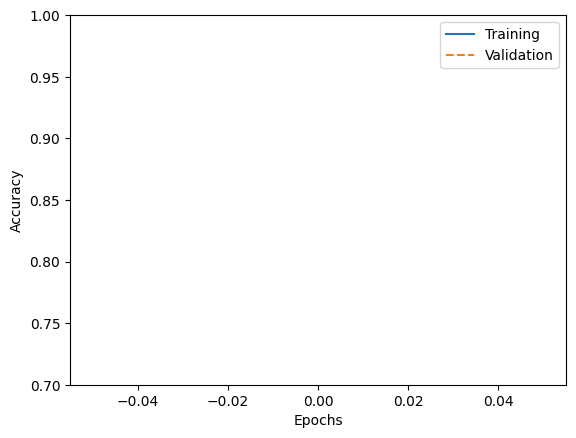

In [56]:
history_1 = model_history.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']



plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

In [57]:
ls

stage1_sample_submission/  stage1_train/                    stage2_test_final/  train/
stage1_solution/           stage1_train_labels/             test/
stage1_test/               stage2_sample_submission_final/  toy_data/


In [70]:
test_img_path = "/content/data/train/images"
test_msk_path = "/content/data/train/masks"


In [71]:
#Capture training image info as a list
test_images_paths = []
test_masks_paths = []

for imgname in os.listdir(images_path):
  test_images_paths.append(os.path.join(test_img_path,imgname))

for imgname in os.listdir(masks_path):
  test_masks_paths.append(os.path.join(test_msk_path,imgname))

In [72]:
test_images_paths.sort()
test_masks_paths.sort()

In [73]:
import keras.backend as K



def dice_coef1(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #print(tf.reduce_sum(y_true_f).numpy(), tf.reduce_sum(y_pred_f).numpy())
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)




In [76]:
import tensorflow as tf
import cv2
import numpy as np
import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define parameters
SIZE_X = 256
SIZE_Y = 256
BATCH_SIZE = 16

# Preprocessing function for images
def preprocess_image(img):
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = preprocessing(img)  # Assuming preprocessing is a predefined function
    return img

# Preprocessing function for masks
def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
    mask[mask != classes['nothing']] = classes['nucleon']  # Set all classes except 'class1' to background
    return mask


def post_process_mask(mask, kernel_size=7, min_area=35, blur_kernel_size=3, debug=False):
    """
    Post-process the predicted mask to remove noise and smooth edges with minimal effect.

    Parameters:
    mask (np.array): Predicted mask.
    kernel_size (int): Size of the kernel for morphological operations.
    min_area (int): Minimum area for connected components to keep.
    blur_kernel_size (int): Kernel size for Gaussian blur to smooth edges.
    debug (bool): If True, plot intermediate steps for debugging.

    Returns:
    np.array: Post-processed mask.
    """
    if mask.ndim > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    if debug:
        plt.figure(figsize=(15, 15))
        plt.subplot(1, 4, 1)
        plt.title("Binary Mask")
        plt.imshow(mask, cmap='gray')

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    if debug:
        plt.subplot(1, 4, 2)
        plt.title("Opened Mask")
        plt.imshow(opened_mask, cmap='gray')

    closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel)

    if debug:
        plt.subplot(1, 4, 3)
        plt.title("Closed Mask")
        plt.imshow(closed_mask, cmap='gray')

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed_mask, connectivity=8)
    output_mask = np.zeros_like(closed_mask)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            output_mask[labels == i] = 255

    if debug:
        plt.subplot(1, 4, 4)
        plt.title("Filtered Mask")
        plt.imshow(output_mask, cmap='gray')
        plt.show()


    return output_mask




# Function to read and preprocess images for the generator
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = preprocess_image(img)
    return img

# Function to read and preprocess masks for the generator
def load_and_preprocess_mask(mask_path):
    mask = preprocess_mask(mask_path)
    return mask

# Create a custom data generator for test images
def test_image_generator(image_paths):
    batch_count = 1
    while batch_count:
        for i in range(0, len(image_paths), BATCH_SIZE):
            batch_image_paths = image_paths[i:i+BATCH_SIZE]
            batch_images = [load_and_preprocess_image(img_path) for img_path in batch_image_paths]
            batch_images = np.array(batch_images)
            yield batch_images

        batch_count = 0

# Create a custom data generator for test masks
def test_mask_generator(mask_paths):
    batch_count = 1
    while batch_count == 1:
        for i in range(0, len(mask_paths), BATCH_SIZE):
            batch_mask_paths = mask_paths[i:i+BATCH_SIZE]
            batch_masks = [load_and_preprocess_mask(mask_path) for mask_path in batch_mask_paths]
            batch_masks = np.array(batch_masks)
            yield batch_masks
        batch_count = 0

# Create generator for the test data
test_img_generator = test_image_generator(test_images_paths)
test_msk_generator = test_mask_generator(test_masks_paths)

# Zip the generators
test_generator = zip(test_img_generator, test_msk_generator)


# # Predict using the model on the test dataset
# predicted_masks = model.predict(test_generator, steps=len(test_images_paths)//BATCH_SIZE, verbose=1)

# # Plotting the results
# for i in range(len(predicted_masks)):
#     plt.figure(figsize=(15, 15))
#     plt.title("Predicted Mask")
#     plt.imshow(np.squeeze(predicted_masks[i]))  # Predicted masks
#     plt.show()


In [81]:
# Dice Scores for segmentation

# THE GENERATOR SHOULD BE AGAIN BE RESET
n_classes = 2
dfs = {}
for i in range(n_classes):
    dfs[i] = []

for batch_images, batch_masks in test_generator:
    for i in range(len(batch_images)):
        test_img = batch_images[i]
        img_mask = batch_masks[i]

        # Assuming create_mask function and dice_coef1 function are defined elsewhere
        predicted_img = np.squeeze(create_mask(model.predict(test_img[np.newaxis, ...])).numpy())

        img_mask_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))
        img_pred_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))
        for j in range(n_classes):
            img_mask_exp[:, :, j][img_mask == j] = 1
            img_pred_exp[:, :, j][predicted_img == j] = 1
            df = dice_coef1(img_mask_exp[:, :, j], img_pred_exp[:, :, j]).numpy()
            dfs[j].append(df)

dfss = []
for i in range(n_classes):
    avg = sum(dfs[i]) / len(dfs[i])
    print(f"Dice score of {str(i)}: {str(avg)}")
    dfss.append(avg)


ZeroDivisionError: division by zero

In [80]:
import random
import matplotlib.pyplot as plt

def display_random_samples_with_postprocessing(image_generator, mask_generator, num_samples=10, debug=False):
    images, masks, predictions, processed_predictions = [], [], [], []
    for batch_images in image_generator:
        batch_masks = next(mask_generator)
        for i in range(len(batch_images)):
            test_img = batch_images[i]
            img_mask = batch_masks[i]

            predicted_img = np.squeeze(create_mask(model.predict(test_img[np.newaxis, ...])).numpy())
            processed_pred_img = post_process_mask(predicted_img,debug=True)

            images.append(test_img)
            masks.append(img_mask)
            predictions.append(predicted_img)
            processed_predictions.append(processed_pred_img)

            if len(images) >= num_samples:
                break
        if len(images) >= num_samples:
            break

    indices = random.sample(range(len(images)), num_samples)
    for idx in indices:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.title("Input Image")
        plt.imshow(images[idx])
        plt.subplot(1, 4, 2)
        plt.title("True Mask")
        plt.imshow(masks[idx], cmap='gray')
        plt.subplot(1, 4, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[idx], cmap='gray')
        plt.subplot(1, 4, 4)
        plt.title("Processed Mask")
        plt.imshow(processed_predictions[idx], cmap='gray')
        plt.show()

# Display 10 random samples with post-processed masks
display_random_samples_with_postprocessing(test_img_generator, test_msk_generator, num_samples=10)


ValueError: Sample larger than population or is negative